# Chapter 5

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import pystan
import arviz

SEED = 1234
np.random.seed(SEED)
sns.set()

## 5.1.2

In [2]:
data_attendance_1_df = pd.read_csv('../data/attendance-1.csv')

In [3]:
data_attendance_1_df.describe()

,A,S,Y
count,50.000000,50.000000,50.00000
mean,0.400000,121.700000,0.26354
std,0.494872,28.136874,0.09747
min,0.000000,51.000000,0.02700
25%,0.000000,105.250000,0.19525
50%,0.000000,120.500000,0.27000
75%,1.000000,142.500000,0.34300
max,1.000000,185.000000,0.42300


In [4]:
data_attendance_1_df.corr('spearman')

,A,S,Y
A,1.00000,-0.002830,-0.738420
S,-0.00283,1.000000,0.425607
Y,-0.73842,0.425607,1.000000


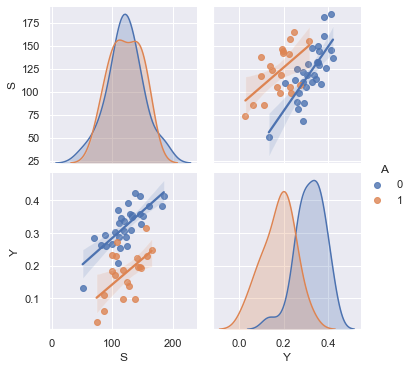

In [5]:
sns.pairplot(data_attendance_1_df, hue='A', kind='reg')

<AxesSubplot:xlabel='A', ylabel='S'>

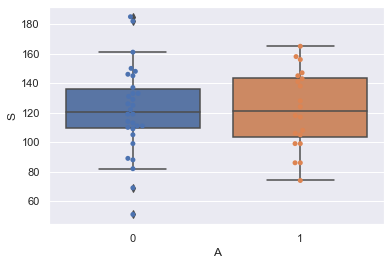

In [6]:
sns.boxplot(x='A', y='S', data=data_attendance_1_df)
sns.swarmplot(x='A', y='S', data=data_attendance_1_df)

<AxesSubplot:xlabel='A', ylabel='Y'>

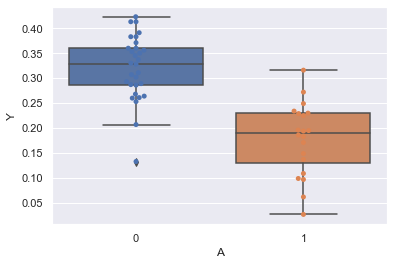

In [7]:
sns.boxplot(x='A', y='Y', data=data_attendance_1_df)
sns.swarmplot(x='A', y='Y', data=data_attendance_1_df)

## 5.1.4

$$
\begin{align}
\mu[n] & = b_1 + b_2 A[n] + b_3 S[n] &n = 1, \dots, N \\
Y[n] &= \mathrm{Normal}(\mu[n], \sigma) &n = 1, \dots, N
\end{align}
$$

## 5.1.5

In [8]:
!cat ../model/main-3.stan

data {
  int N;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> S[N];
  real<lower=0, upper=1> Y[N];
}

parameters {
  real b_1;
  real b_2;
  real b_3;
  real<lower=0> sigma;
}

transformed parameters {
  real mu[N];

  for (n in 1:N) {
    mu[n] = b_1 + b_2 * A[n] + b_3 * S[n];
  }
}

model {
  for (n in 1:N) {
    Y[n] ~ normal(mu[n], sigma);
  }
}

generated quantities {
  real Y_pred[N];

  for (n in 1:N) {
    Y_pred[n] = normal_rng(mu[n], sigma);
  }
}


## 5.1.6

In [9]:
model = pystan.StanModel('../model/main-3.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bf6e64b63aff2f725e0b84d4f9581e7f NOW.


In [10]:
data_attendance_1_dict =  data_attendance_1_df.to_dict('list')
data_attendance_1_dict['S'] = data_attendance_1_df['S'] / 200
data_attendance_1_dict['N'] = len(data_attendance_1_df)

In [11]:
fit = model.sampling(data_attendance_1_dict, seed=SEED, n_jobs=1)

In [12]:
print(fit)

Inference for Stan model: anon_model_bf6e64b63aff2f725e0b84d4f9581e7f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b_1          0.12  8.5e-4   0.03   0.06    0.1   0.12   0.15   0.19   1538    1.0
b_2         -0.14  3.0e-4   0.01  -0.17  -0.15  -0.14  -0.13  -0.11   2485    1.0
b_3          0.32  1.3e-3   0.05   0.22   0.29   0.33   0.36   0.43   1533    1.0
sigma        0.05  1.2e-4 5.5e-3   0.04   0.05   0.05   0.06   0.06   2085    1.0
mu[1]        0.24  4.1e-4   0.02    0.2   0.22   0.24   0.25   0.27   1724    1.0
mu[2]        0.21  2.8e-4   0.01   0.19   0.21   0.22   0.22   0.24   2195    1.0
mu[3]        0.33  1.7e-4 9.7e-3   0.31   0.32   0.33   0.33   0.35   3264    1.0
mu[4]        0.12  3.2e-4   0.01   0.09   0.11   0.12   0.13   0.15   2161    1.0
mu[5]        0.24  3.4e-4   0.02   0.21   0.23   0.24   0.25   0.27   197

array([[<AxesSubplot:title={'center':'b_1'}>,
        <AxesSubplot:title={'center':'b_1'}>],
       [<AxesSubplot:title={'center':'b_2'}>,
        <AxesSubplot:title={'center':'b_2'}>],
       [<AxesSubplot:title={'center':'b_3'}>,
        <AxesSubplot:title={'center':'b_3'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

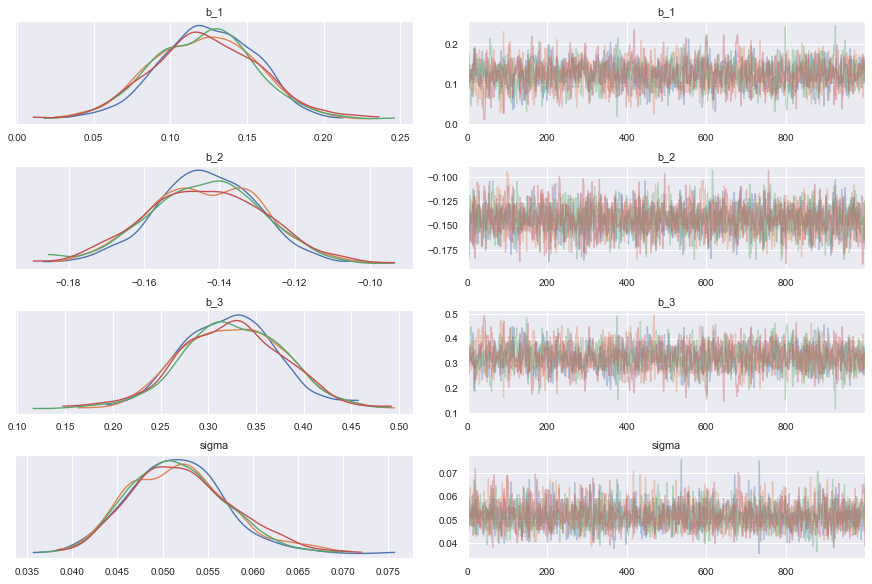

In [13]:
arviz.plot_trace(fit, var_names=['b_1', 'b_2', 'b_3', 'sigma'])

## 5.1.8

In [14]:
sample = fit.extract()
sample.keys()

odict_keys(['b_1', 'b_2', 'b_3', 'sigma', 'mu', 'Y_pred', 'lp__'])

In [15]:
Y_pred_quantile = np.percentile(sample['Y_pred'], q=[10, 50, 90], axis=0)

In [16]:
def plot_fig_5_2():
    def plot_per_A(A, color):
        cond = (data_attendance_1_df['A'] == A)
        df = pd.DataFrame({
            'S': data_attendance_1_df[cond]['S'],
            'Y': data_attendance_1_df[cond]['Y'],
            'Y_p10': Y_pred_quantile[0, cond],
            'Y_p50': Y_pred_quantile[1, cond],
            'Y_p90': Y_pred_quantile[2, cond]
        })
        sns.scatterplot(x='S', y='Y', data=df, color=color)
        ax = sns.lineplot(x='S', y='Y_p50', data=df, color=color)
        ax.fill_between(x='S', y1='Y_p10', y2='Y_p90', data=df.sort_values('S'), color=color, alpha=0.25)
        ax.set_ylabel('Y and Y_pred')

    plot_per_A(0, 'b')
    plot_per_A(1, 'r')


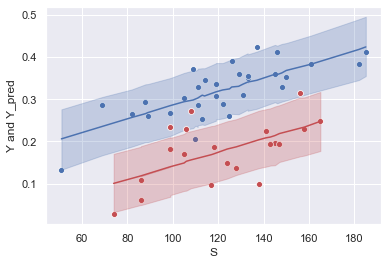

In [17]:
plot_fig_5_2()

In [18]:
def plot_fig_5_3():
    df = pd.concat([
        data_attendance_1_df,
        pd.DataFrame({
            'Y_p10': Y_pred_quantile[0],
            'Y_p50': Y_pred_quantile[1],
            'Y_p90': Y_pred_quantile[2]
        })
    ], axis=1)

    def plot_per_A(A, color):
        df_ = df[df['A'] == A]
        ax = sns.scatterplot(x='Y', y='Y_p50', data=df_, color=color)
        ax.vlines(x=df_['Y'], ymin=df_['Y_p10'], ymax=df_['Y_p90'], color=color, alpha=0.5)

    def plot_identical(color, style):
        ax = sns.lineplot(x=np.linspace(0, 0.5), y=np.linspace(0, 0.5), color=color)
        ax.lines[0].set_linestyle(style)
        ax.set_ylabel('Y_pred')


    plot_per_A(0, 'b')
    plot_per_A(1, 'r')
    plot_identical('grey', ':')
    pass

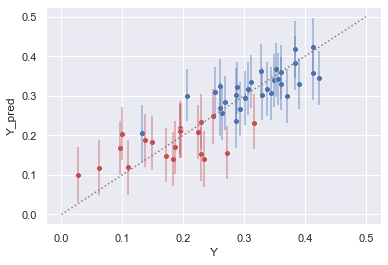

In [19]:
plot_fig_5_3()

In [20]:
error = data_attendance_1_df['Y'][:, np.newaxis] - sample['Y_pred'].T
error.shape

<ipython-input-20-723df469c9cd>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  error = data_attendance_1_df['Y'][:, np.newaxis] - sample['Y_pred'].T


(50, 4000)

In [21]:
def plot_fig_5_4_left():
    from scipy.stats import gaussian_kde

    color = 'b'
    modes = []

    for i in range(error.shape[0]):
        ax = sns.kdeplot(error[i], color='b')
        density = gaussian_kde(error[i])
        j_max = density(error[i]).argmax()
        mode = error[i, j_max]
        ax.vlines(x=mode, ymin=0, ymax=density(mode), color=color, linestyles='dashed', alpha=0.5)
        modes.append(mode)

    sns.rugplot(modes, color=color)

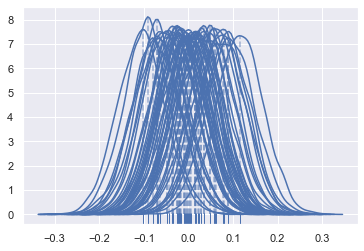

In [22]:
plot_fig_5_4_left()

In [23]:
def plot_fig_5_4_right():
    from scipy.stats import gaussian_kde, norm

    def get_error_modes():
        modes = []

        for i in range(error.shape[0]):
            density = gaussian_kde(error[i])
            j_max = density(error[i]).argmax()
            mode = error[i, j_max]
            modes.append(mode)

        return modes

    def get_sigma_mode():
        density = gaussian_kde(sample['sigma'])
        i_max = density(sample['sigma']).argmax()
        return sample['sigma'][i_max]

    error_modes = get_error_modes()
    sns.distplot(error_modes, bins=20, color='b')
    x = sorted(set(error_modes))
    ax = sns.lineplot(x=x, y=norm.pdf(x, 0, get_sigma_mode()))
    ax.lines[0].set_linestyle('--')
    ax.lines[0].set_color('r')


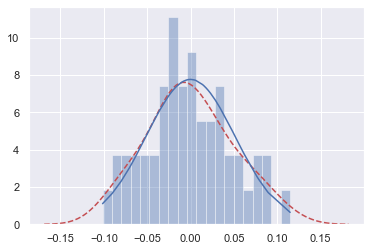

In [24]:
plot_fig_5_4_right()

In [25]:
fit_df = fit.to_dataframe()

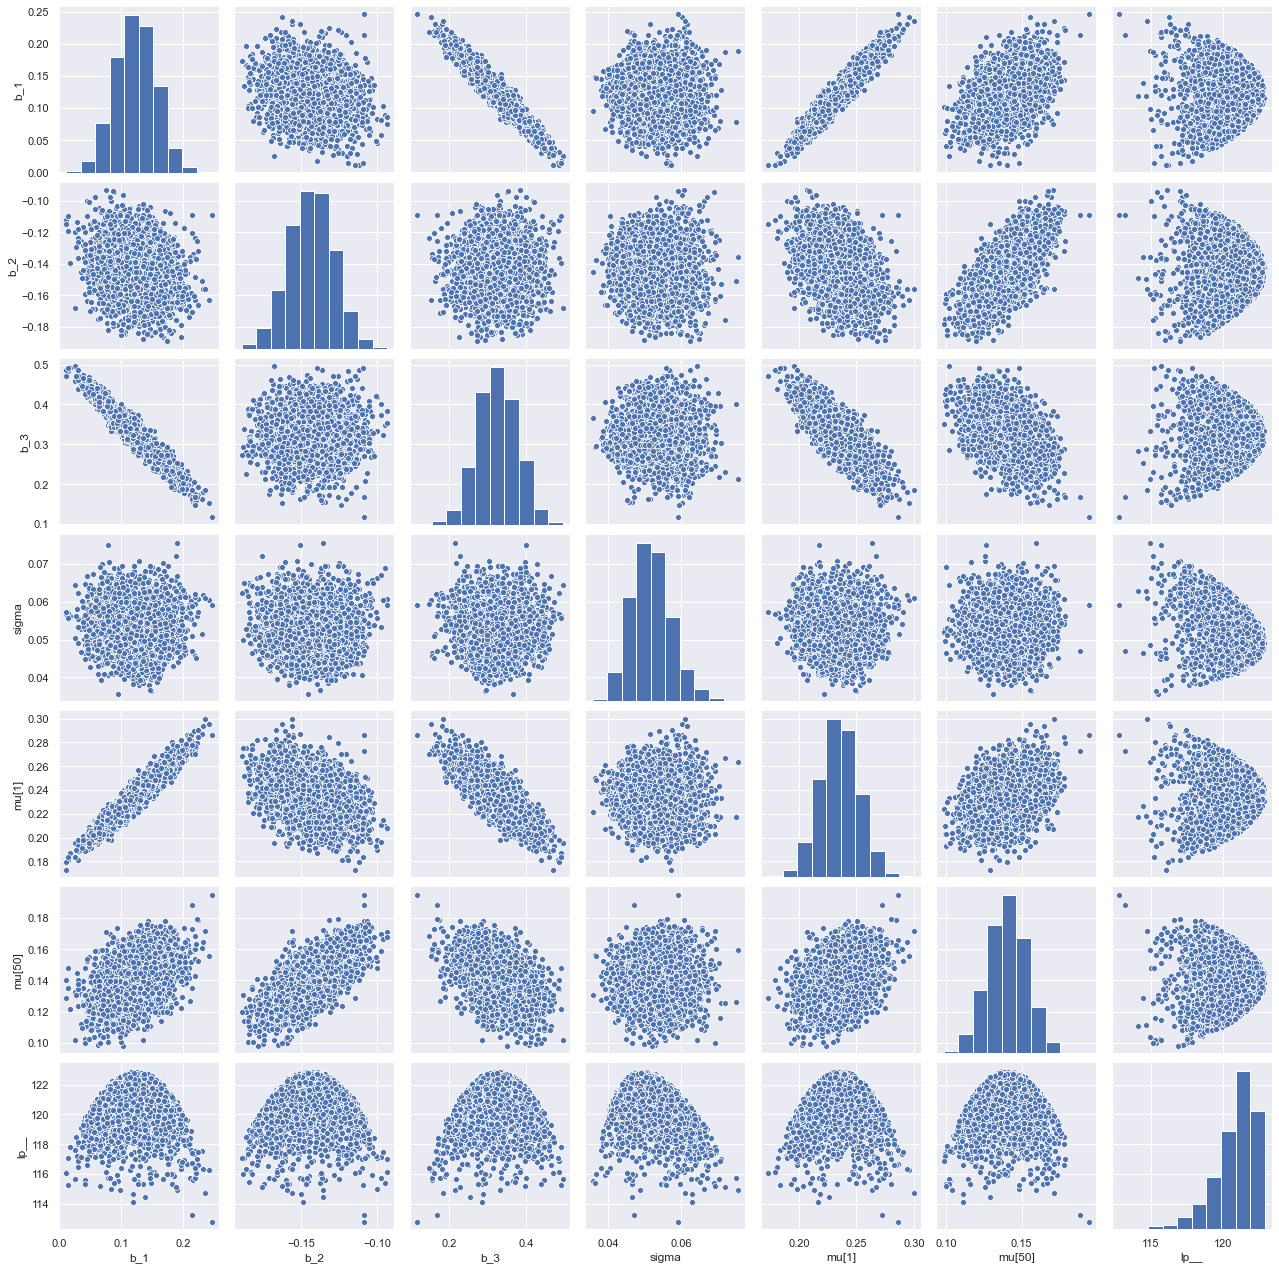

In [26]:
sns.pairplot(fit_df[['b_1', 'b_2', 'b_3', 'sigma', 'mu[1]', 'mu[50]', 'lp__']])

In [27]:
fit_df[['b_1', 'b_2', 'b_3', 'sigma', 'mu[1]', 'mu[50]', 'lp__']].corr('spearman')

,b_1,b_2,b_3,sigma,mu[1],mu[50],lp__
b_1,1.000000,-0.180776,-0.953596,0.023028,0.947089,0.420769,-0.012690
b_2,-0.180776,1.000000,0.006118,-0.013036,-0.351867,0.664400,-0.003624
b_3,-0.953596,0.006118,1.000000,-0.024530,-0.809671,-0.437674,0.016666
sigma,0.023028,-0.013036,-0.024530,1.000000,0.018402,-0.006560,-0.268046
mu[1],0.947089,-0.351867,-0.809671,0.018402,1.000000,0.361896,-0.002091
mu[50],0.420769,0.664400,-0.437674,-0.006560,0.361896,1.000000,0.001851
lp__,-0.012690,-0.003624,0.016666,-0.268046,-0.002091,0.001851,1.000000
